<h1><center> MODEL </center></h1>

 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    <b>Lipanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

[comment]: <> (Paketi koje je potrebno instalirati prije pokretanja bilježnice: <br>)
[comment]: <> (<code>conda install -c anaconda py-xgboost</code> <br>)
[comment]: <> (<code>conda install -c conda-forge imbalanced-learn</code>)

In [1]:
# packages
import numpy as np
from numpy import mean
from numpy import std
from numpy import loadtxt
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.core.pylabtools import figsize
from collections import Counter
import random

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import precision_score, log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.utils import class_weight

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from functions.model_helper import *

from yellowbrick.classifier import ClassBalance, ROCAUC
from yellowbrick.classifier import ClassificationReport, ClassPredictionError

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


C:\Users\Matea\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# remember default python style
IPython_default = plt.rcParams.copy()

In [3]:
# dictionary for saving malware names
malware_dict = { 1 : 'Ramnit', 2 : 'Lollipop', 3 : 'Kelihos_ver3', 4 : 'Vundo', 5 : 'Simba', 
                 6 : 'Tracur', 7 : 'Kelihos_ver1', 8 : 'Obfuscator.ACY', 9 : 'Gatak'}

In [4]:
# loading all features in train set
features_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")
features_train.head()

# loading all features in train set
features_test1 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_first_10000.csv")
features_test2 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_last_873.csv")
features_test = features_test1.append(features_test2)

In [ ]:
md5hash_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_train.csv")
features_train_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_train_with_filled_NaN_without_id.csv")

md5hash_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_test.csv")
features_test_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_test_with_filled_NaN_without_id.csv")

In [5]:
# load train data malware classes
malware_classes_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/malware_classes_train.csv")

In [6]:
# load features from train and test dataset given using rfecv
selected_features_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/selected%20features/rfc/selected_features_rfc_train_cv2_186.csv")
selected_features_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/selected%20features/rfc/selected_features_rfc_test_cv2_186.csv")

# load table with feature names and their scores, sorted
feature_importances = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/selected%20features/rfc/rfecv_cv2_186_feature_selected_with_names_and_importance_scores_sorted.csv")

In [7]:
feature_importances.head()

,feature_name,feature_importance
0,_allmul,0.025009
1,ent_q_diff_diffs_1_min,0.024926
2,ent_q_diff_diffs_1_median,0.021725
3,GetStringTypeA,0.021289
4,byte_1G_a2,0.019825


In [8]:
# setting random seed
seed = 47

In [9]:
# groups of features
one_gram_features = features_train_with_filled_NaN_without_id.iloc[:,:256]
metadata_bytes_features = features_train_with_filled_NaN_without_id.iloc[:,256:258]
entropy_features = features_train_with_filled_NaN_without_id.iloc[:,258:460]
image_features = features_train_with_filled_NaN_without_id.iloc[:,460:512]
string_length_features = features_train_with_filled_NaN_without_id.iloc[:,512:628]
metadata_asm_features = features_train_with_filled_NaN_without_id.iloc[:,628:630]
symbols_features = features_train_with_filled_NaN_without_id.iloc[:,630:637]
opcode_features = features_train_with_filled_NaN_without_id.iloc[:,637:730]
reg_features = features_train_with_filled_NaN_without_id.iloc[:,730:756]
section_features = features_train_with_filled_NaN_without_id.iloc[:,756:780]
dd_features = features_train_with_filled_NaN_without_id.iloc[:,780:804]
api_features = features_train_with_filled_NaN_without_id.iloc[:,804:1598]
key_features = features_train_with_filled_NaN_without_id.iloc[:,1598:1693]

In [10]:
# define number of features to use
number_of_features_to_use = len(feature_importances["feature_name"].values)

In [11]:
# define data
data = selected_features_train[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]
labels = malware_classes_train.values.ravel()

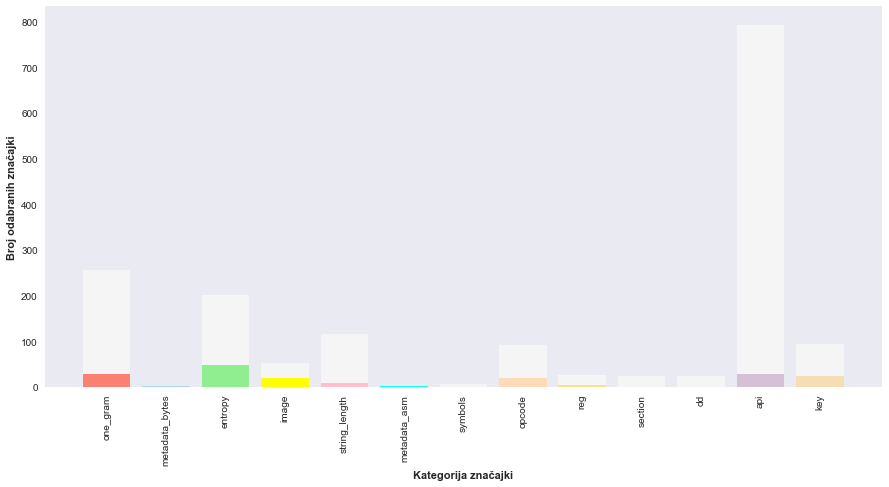

In [110]:
from functions.fs_helper import *

features_type_quantity(feature_importances["feature_name"].tolist(), features_train)

In [12]:
# split data
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.3, random_state=seed)

<br>

# XGBoost

<span style="color:orange"><i>Objasniti ukratko zašto smo odabrali ovaj klasifikator. ~> copy-paste sa nekih od starih radova </i></span>

<span style="color:orange"><i>Ovdje sam ja samo pokušavala skužiti što se radi pa sam na basic modelu crtala i ispisivala sve što trebamo napraviti za najbolji model ili tako nesto.</i></span>

In [13]:
# xgboost with default parameters
basic_model_xgb = XGBClassifier_load_or_make(X_train, y_train, X_test, y_test)

Load or make XGBClassifier?load
Izaberi XGBClassifier:
1. basic_model_xgb.sav
1


In [14]:
model = basic_model_xgb

<span style="color:orange"><i>Ispisivanje različitih scoreova najboljeg modela pronađenog prethodnom metodom.</i></span>

In [15]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.020555
1,accuracy_test,0.992947
2,F1_test,0.992860
3,precision_test,0.993045
4,auc_test_ovr,0.999789
5,auc_test_ovo,0.999616
6,r2_test,0.976450


<span style="color:orange"><i>Klasik, ovdje ćemo samo napisati očito, da nam je problem ta najmanja klasa malwarea i da smo zbog toga radili oversampling.</i></span>

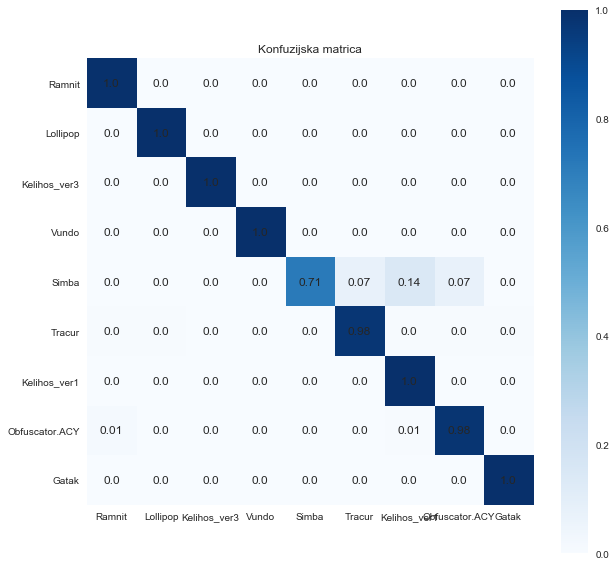

In [16]:
plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

<span style="color:orange"><i>Njihova željena <b>undercurve</b>. Oke vidim da je za Simbu najgora ofc.</i></span>

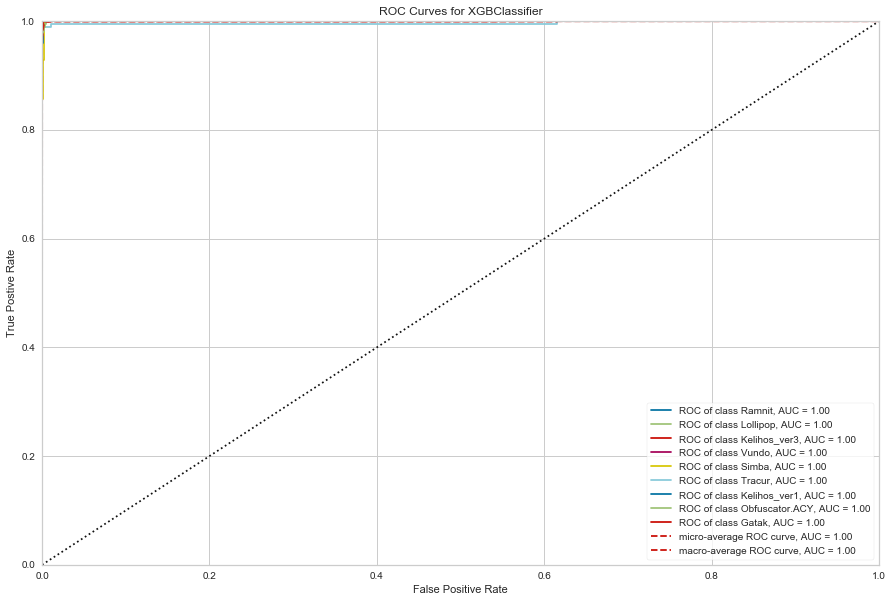

In [17]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#plt.style.use(plt.style.available[20])
plt.rcParams.update(IPython_default);

rocauc = ROCAUC(model, size=(1080, 720), classes=list(malware_dict.values()), encoder=malware_dict )

rocauc.score(X_test, y_test)    
r = rocauc.poof()

<span style="color:orange"><i>Precision i recall. Iz ovog vidim da svaki put pogosi Simbu, ako je pogodi. Ali je ne pogodi svaki put jer je recall mali, odnosno ima dosta podataka koji su bili simba a nije ih prepoznao. Zato sam dolje ispisala iz dataframe sve retke u kojima je prediction za simbu bi iole veći od 0.1. Pa ću to možda malo proučiti. Isto sam otvorila excelicu pa idem po featurima da vidim ima li neki koji ističe simu jer ovdje nisam dobila neke informacije: https://www.hybrid-analysis.com/sample/f177c28aea4067de9056c8ccff9a7408561c945f96d55baf6b9d70543031f018?environmentId=100</i></span>

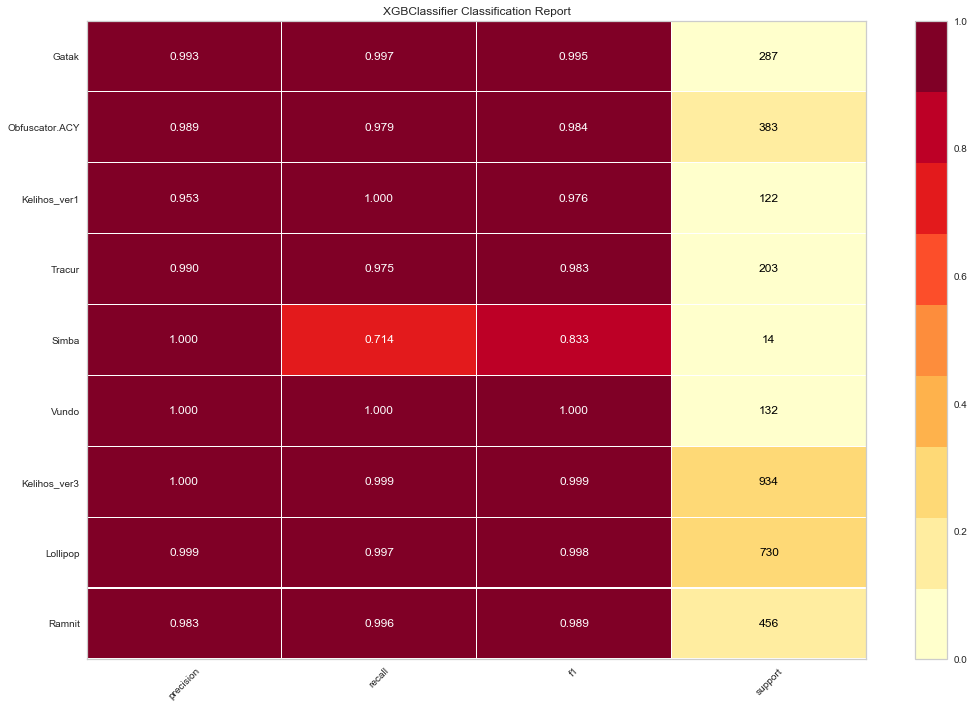

In [18]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

<span style="color:orange"><i>Ovo je super graf koji prikazuje po klasama malwarea koje je loše svrstao i gdje, vizualno. Živcira me što su iste boje nisam sigurna kako to riješiti.</i></span>

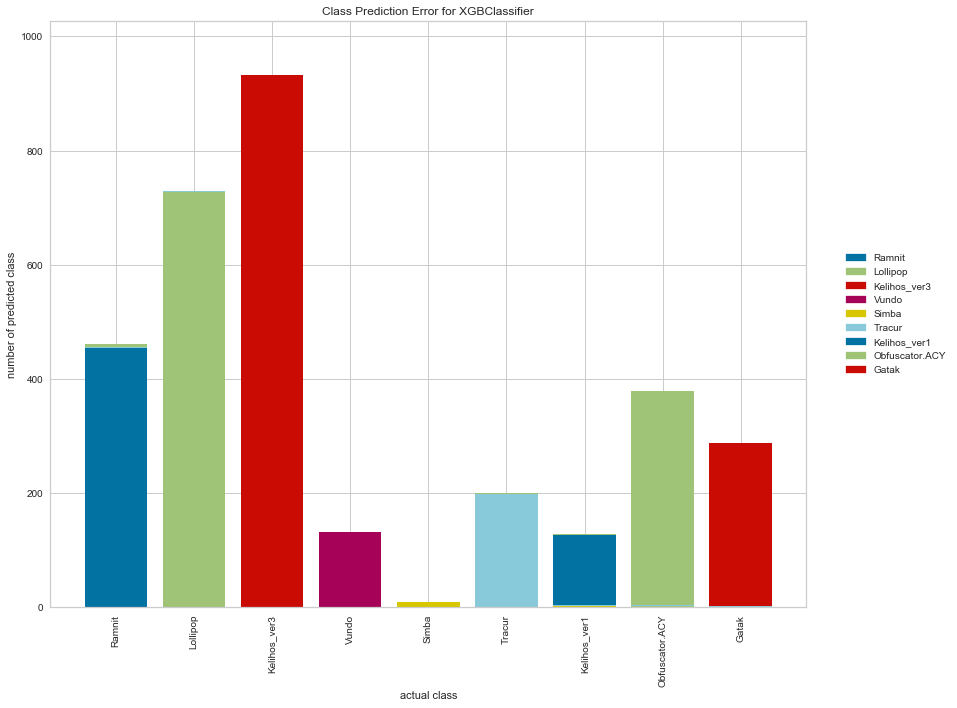

In [19]:
error = ClassPredictionError(model, size=(1080, 720), classes=list(malware_dict.values()), encoder=malware_dict)

error.score(X_test, y_test)
e = error.poof()

<span style="color:orange"><i>Izvšavanje malo duže traje pa sam zakomentirala. Crtaju se learning curve (po accuracy scoreu), logloss krivulja i classification error krivulja po broju podataka u training setu.</i></span>

In [ ]:
#plot_learning_curve( model, X_train, y_train, X_test, y_test, 2, seed)

<span style="color:orange"><i>Važnost značajki. Kako ovo objasnit, ja ne znam. </i> </span>

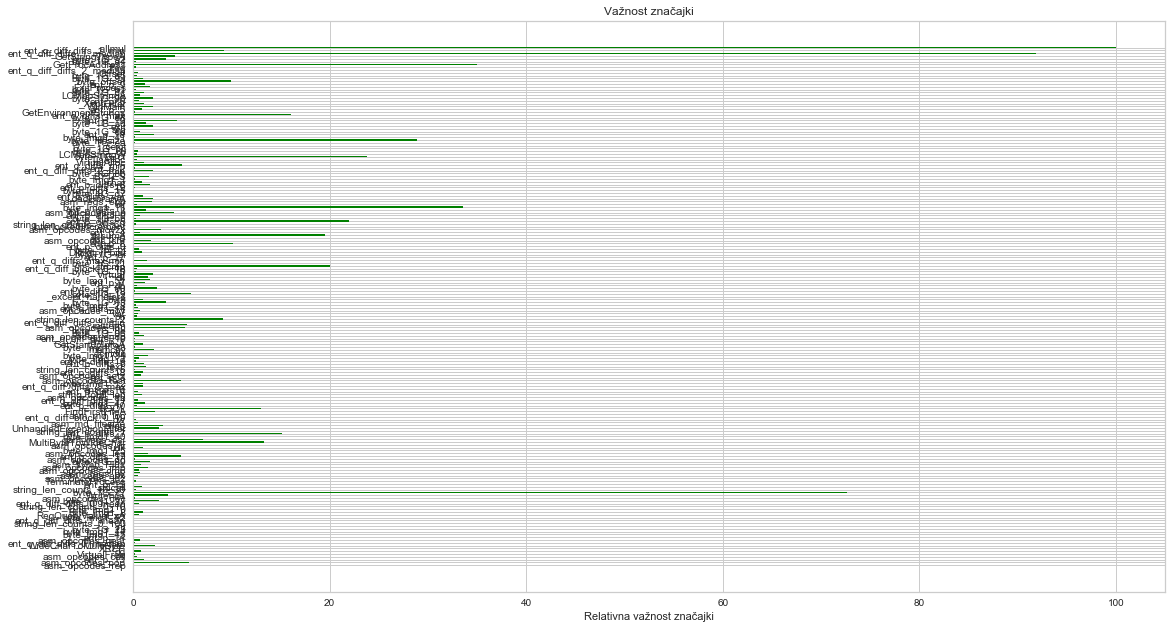

In [20]:
plot_feature_importance(model, list(feature_importances["feature_name"].values[:number_of_features_to_use]))

Broj malwarea po klasama:
dict_values([1558, 2218, 2944, 474, 105, 500, 384, 1652, 1038])
Postotci malwarea po klasama:
[14.329072013243815, 20.39915386737791, 27.076243906925413, 4.359422422514485, 0.965694840430424, 4.598546859192496, 3.5316839878598363, 15.193598822772003, 9.54658327968362]


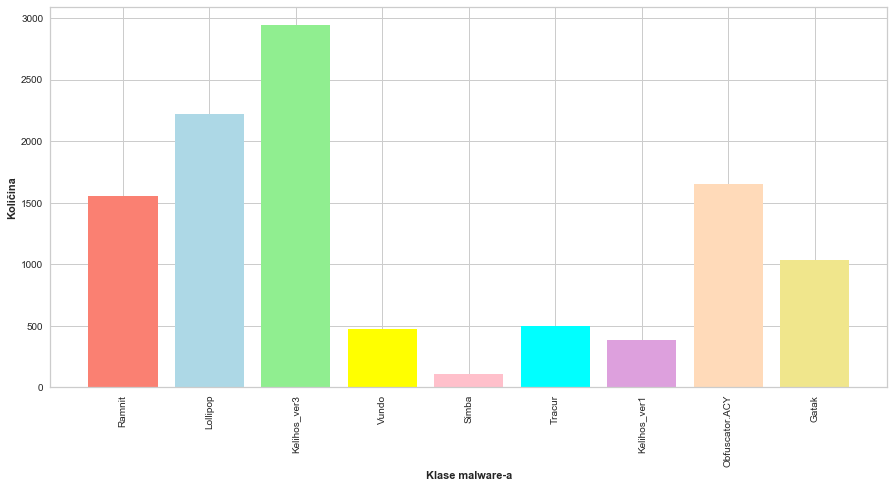

In [21]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

<span style="color:orange"><i>score:0.55</i></span>

<br><br>

## XGBoost Parameter Tuning

<span style="color:orange"><i>Ovdje pokušavamo naći još bolji model tako da isprobavamo različite parametre XGBoosta. </i> </span>

In [22]:
# data
data = selected_features_train[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]
labels = malware_classes_train.values.ravel()

X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.3, random_state=seed)

In [23]:
# get XGBClassifier parameters names
XGBClassifier().get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

<span style="color:orange"><i>Definiranje svih parametara koje će pretraživati. </i> </span>

In [24]:
# define the parameter values that should be searched
n_estimators_range = [int(x) for x in np.linspace(start=70, stop=500, num=10)]

# learning range
learning_range = list(range(1, 31))
learning_range = [x / 10 for x in learning_range]

# regularization parameters
gamma = [ 0, 0.001, 0.005, 0.01, 0.1, 0.5] #default 0
reg_alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] #default 0
reg_lambda = [0, 0.01, 0.1, 0.5, 0.75, 1] #default 1

#max depth of tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# method of selecting samples for training each tree
bootstrap = [True, False]

# dictionary of parameters
random_grid = {
               'n_estimators': n_estimators_range,
               'learning_rate': learning_range,
               'max_features': ['auto','log2'],
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'gamma' : gamma,
               'reg_alpha': reg_alpha,
               'reg_lambda': reg_lambda
              }

Load or make RandomizedSearchCV?load
Izaberi RandomizedSearchCV:
1. RandomizedSearchCV10_basic_all_features_neg_log_loss 
1


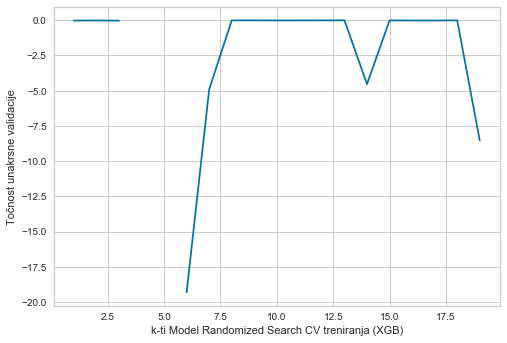

In [25]:
# we use the RandomizedSearchCV to find the best parameters for our XGB model
[rand_XGB_model, rand_XGB_results_df] = RandomizedSearchCV_load_or_make(data=data, labels=labels, random_grid=random_grid, cv=10, scoring="neg_log_loss", n_iter=20, random_state=seed)

In [34]:
rand_XGB_results_df

,mean_test_score,std_test_score,params,rank_test_score
0,-0.031969,0.012740,"{'reg_lambda': 0.5, 'reg_alpha': 0.05, 'n_esti...",12
1,-0.020498,0.009558,"{'reg_lambda': 0, 'reg_alpha': 0.001, 'n_estim...",8
2,-0.035827,0.012876,"{'reg_lambda': 0.01, 'reg_alpha': 0.001, 'n_es...",13
3,NaN,NaN,"{'reg_lambda': 0.75, 'reg_alpha': 0.05, 'n_est...",19
4,NaN,NaN,"{'reg_lambda': 0.75, 'reg_alpha': 0, 'n_estima...",18
5,-19.302016,12.767443,"{'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_est...",17
6,-4.908237,5.953830,"{'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimat...",15
7,-0.018419,0.007191,"{'reg_lambda': 0.01, 'reg_alpha': 0.001, 'n_es...",5
8,-0.017598,0.007802,"{'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_esti...",3
9,-0.020458,0.008032,"{'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_est...",7


In [27]:
model = rand_XGB_model

<span style="color:orange"><i>Tri najbolja skupa parametara. </i> </span>

In [35]:
from functions.model_helper import *

# examine the best n models
n = 3
best_n_models_params = report(rand_XGB_results_df, n_top=3)

Model ranga: 1
Mean validation score: -0.01608 (std: 0.00729)
Parametri: {'reg_lambda': 1, 'reg_alpha': 0.005, 'n_estimators': 165, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'learning_rate': 0.4, 'gamma': 0.01, 'bootstrap': False}

Model ranga: 2
Mean validation score: -0.01628 (std: 0.00745)
Parametri: {'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 165, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 60, 'learning_rate': 0.7, 'gamma': 0.005, 'bootstrap': False}

Model ranga: 3
Mean validation score: -0.01760 (std: 0.00780)
Parametri: {'reg_lambda': 0.1, 'reg_alpha': 0.01, 'n_estimators': 404, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 90, 'learning_rate': 0.4, 'gamma': 0.01, 'bootstrap': True}



<br> 

### GridSearch

<span style="color:orange"><i>GridSearch pomnije i detaljnije pretražuje prostor parametara. Stavljam mu da pretraži prostor oko već dobivenih najboljih parametara sa RandomSearch. Još mi se niti jedan nije izvrtio. Možda bi bilo bolje na jednom skupu parametara, ovako predugo traje.</i> </span>

In [36]:
param_grid = {    'reg_lambda': [],
                  'reg_alpha': [],
                  'n_estimators': [],
                  'min_samples_split': [],
                  'min_samples_leaf': [],
                  'max_features': [],
                  'max_depth': [],
                  'learning_rate': [],
                  'gamma': [],
                  'bootstrap': []
              }

# adding parameters to be examined with GridSearch in params_grid
for key in param_grid.keys():
    for i in range(len(best_n_models_params)):
        if best_n_models_params[i][key] not in param_grid[key]:
            param_grid[key].append(best_n_models_params[i][key])
            
param_grid

{'reg_lambda': [1, 0.1],
 'reg_alpha': [0.005, 0.1, 0.01],
 'n_estimators': [165, 404],
 'min_samples_split': [10, 2, 5],
 'min_samples_leaf': [2, 4],
 'max_features': ['auto', 'log2'],
 'max_depth': [20, 60, 90],
 'learning_rate': [0.4, 0.7],
 'gamma': [0.01, 0.005],
 'bootstrap': [False, True]}

In [37]:
[grid_search, grid_search_results_df] = GridSearchCV_load_or_make(param_grid=param_grid, data=data, labels=labels, cv=5)

Load or make GridSearchCV?load
Još nema opcija.


ValueError: Nije upisano load ili make - pri učitavanju GridSearchCV_load_or_make!

In [38]:
grid_search_results_df

NameError: name 'grid_search_results_df' is not defined

In [40]:
from functions.model_helper import *

# examine the best n models
n = 3
best_n_models_params = report(grid_search.cv_results_, n_top=3)

NameError: name 'grid_search' is not defined

In [39]:
[param_tuning_xgb, param_tuning_xgb_results_df] = XGBClassifier_with_params(grid_search, X_train, y_train, X_test, y_test, early_stopping_rounds=20, eval_metric=["merror", "mlogloss"])

NameError: name 'grid_search' is not defined

In [41]:
model = param_tuning_xgb

NameError: name 'param_tuning_xgb' is not defined

<br><br>

## Nebalansiranost podataka

<span style="color:orange"><i>Dakle rješavamo problem što nam je Simbe premalo.. </i> </span>

Broj malwarea po klasama:
dict_values([1541, 2477, 2942, 475, 42, 751, 398, 1228, 1013])
Postotci malwarea po klasama:
[14.180546608999725, 22.793779331922334, 27.072789178246065, 4.371031563448974, 0.38649121192601454, 6.91083095610564, 3.662464341584614, 11.300266862979663, 9.321799944786969]


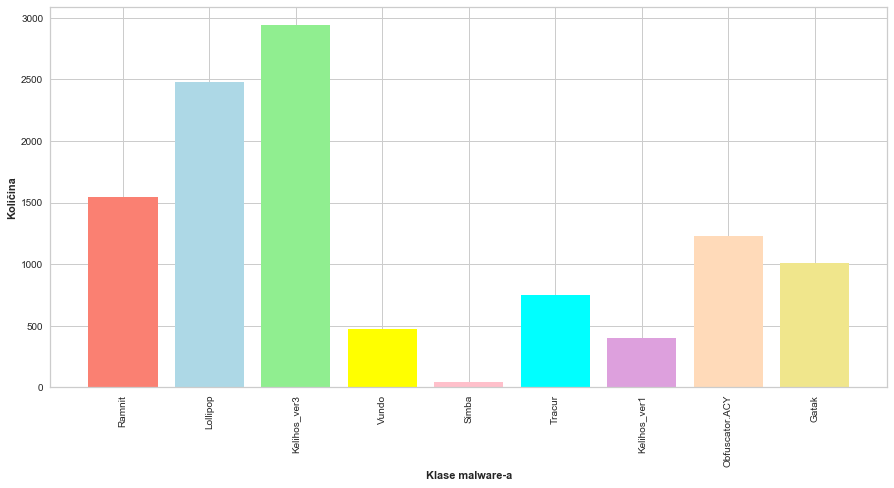

In [44]:
draw_malware_distribution_over_classes(malware_classes_train.values.ravel())

In [48]:
# za sad imam ove parametre kao najbolje
best_models_params = rand_XGB_model.best_params_
best_models_params

{'reg_lambda': 1,
 'reg_alpha': 0.005,
 'n_estimators': 165,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 20,
 'learning_rate': 0.4,
 'gamma': 0.01,
 'bootstrap': False}

<br>

### Dodavanje težina

In [50]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.3, random_state=seed)

# adding weights in xgboost
class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train),y_train))
w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]

xgb_classifier_weights = xgb.XGBClassifier(n_jobs=-1, verbose=True)
xgb_classifier_weights.set_params(**best_models_params)
xgb_classifier_weights.fit(X_train, y_train, sample_weight=w_array)


XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=False,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0.01, learning_rate=0.4, max_delta_step=0, max_depth=20,
              max_features='auto', min_child_weight=1, min_samples_leaf=2,
              min_samples_split=10, missing=None, n_estimators=165, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbose=True, verbosity=1)

In [ ]:
model = xgb_classifier_weights

In [52]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.017637
1,accuracy_test,0.995094
2,F1_test,0.995076
3,precision_test,0.995156
4,auc_test_ovr,0.999904
5,auc_test_ovo,0.999811
6,r2_test,0.987578


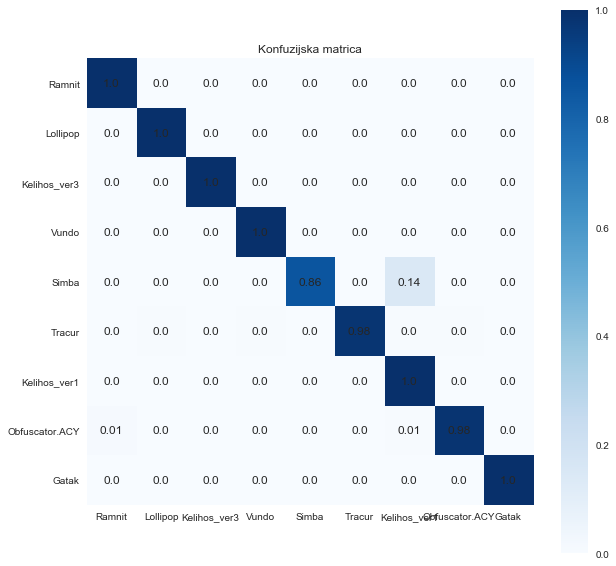

In [53]:
plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

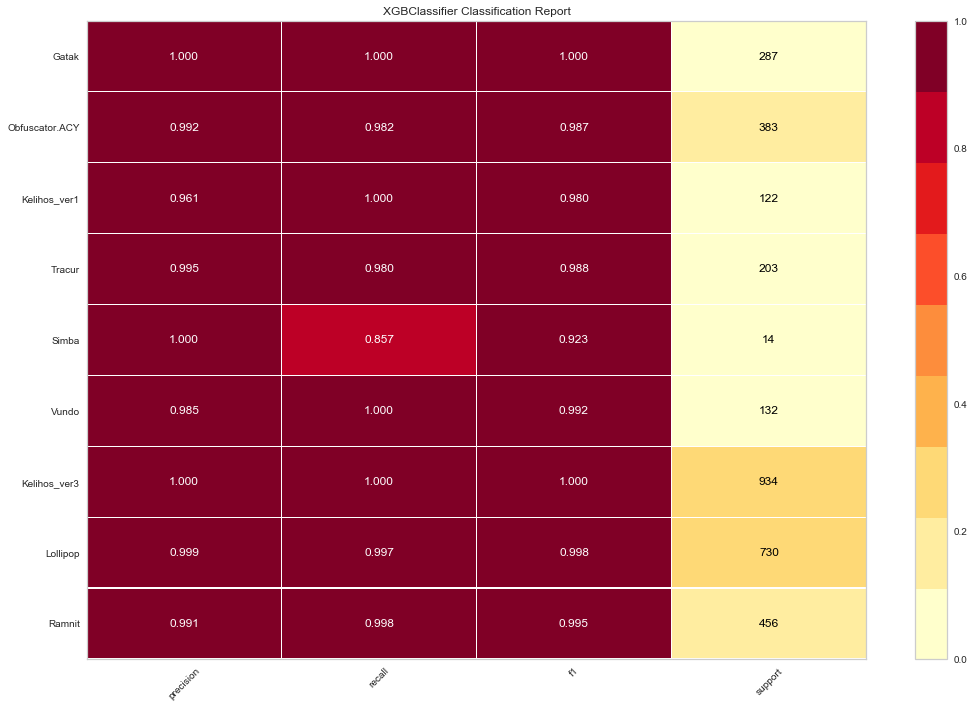

In [55]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

Broj malwarea po klasama:
dict_values([1443, 1766, 2942, 481, 54, 640, 397, 2107, 1043])
Postotci malwarea po klasama:
[13.27140623562954, 16.242067506667894, 27.05784971948864, 4.42380207854318, 0.49664306079278947, 5.886139979766393, 3.651246206198841, 19.378276464637175, 9.592568748275546]


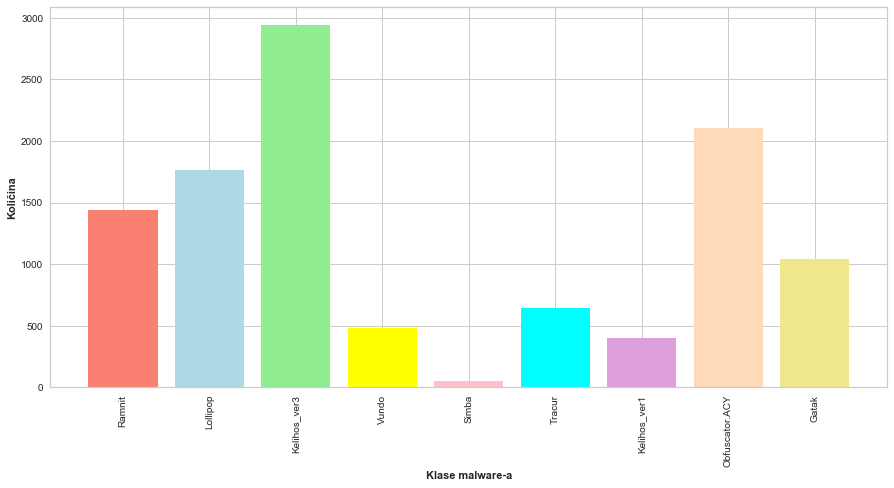

In [56]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

<span style="color:orange"><i>score:0.58</i></span>


<br>

## RandomOverSampler

In [59]:
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

xgb_classifier_ros = xgb.XGBClassifier(n_jobs=-1, verbose=True)
xgb_classifier_ros.set_params(**best_models_params)
xgb_classifier_ros.fit(X_train, y_train)

[(1, 2008), (2, 2008), (3, 2008), (4, 2008), (5, 2008), (6, 2008), (7, 2008), (8, 2008), (9, 2008)]


XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=False,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0.01, learning_rate=0.4, max_delta_step=0, max_depth=20,
              max_features='auto', min_child_weight=1, min_samples_leaf=2,
              min_samples_split=10, missing=None, n_estimators=165, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbose=True, verbosity=1)

In [60]:
model = xgb_classifier_ros

In [61]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.019452
1,accuracy_test,0.993867
2,F1_test,0.993822
3,precision_test,0.993946
4,auc_test_ovr,0.999854
5,auc_test_ovo,0.999747
6,r2_test,0.983006


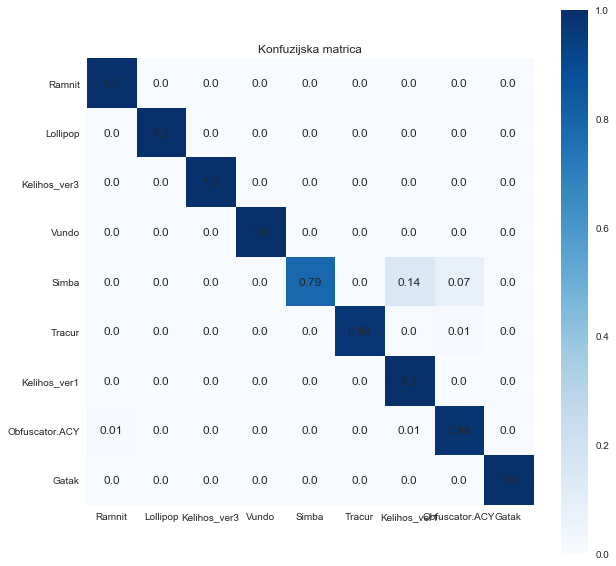

In [62]:
plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

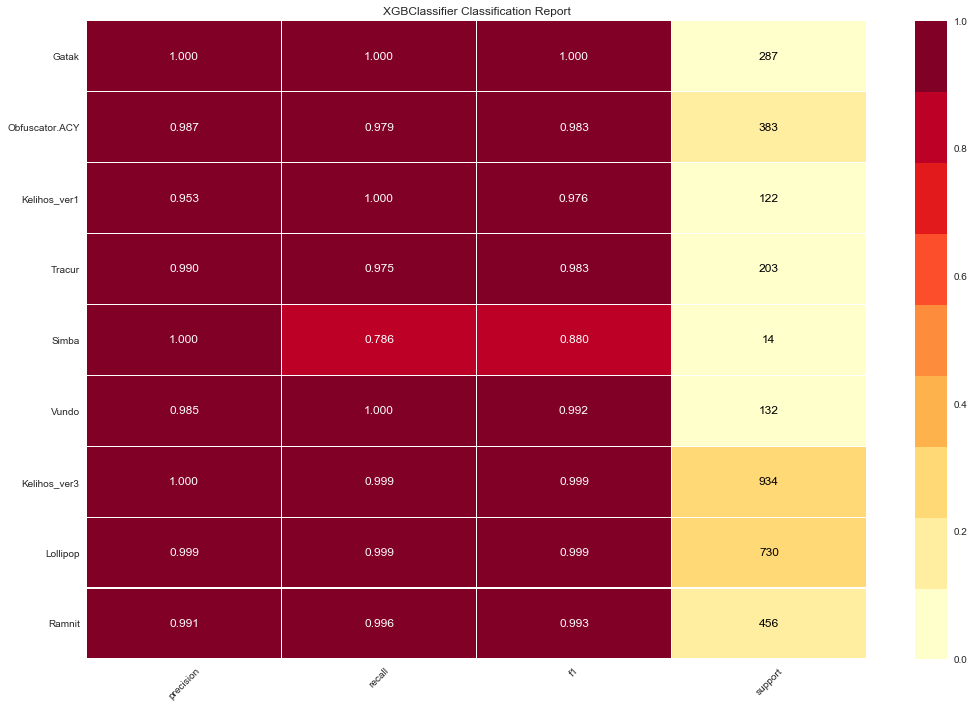

In [63]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()


Broj malwarea po klasama:
dict_values([1408, 1898, 2943, 478, 52, 751, 396, 1959, 988])
Postotci malwarea po klasama:
[12.949507955486068, 17.456083877494713, 27.067046813207025, 4.396210797388026, 0.4782488733560195, 6.907017382507127, 3.642049112480456, 18.017106594316196, 9.08672859376437]


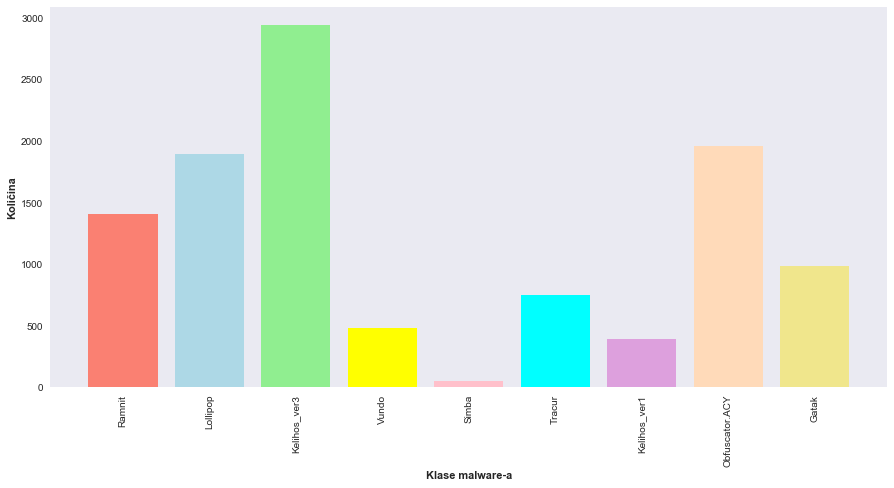

In [64]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

<span style="color:orange"><i>score:0.59</i></span>

<br>

## Smote

In [66]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.3, random_state=seed)

X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

xgb_classifier_smote = xgb.XGBClassifier(n_jobs=-1, verbose=True)
xgb_classifier_smote.set_params(**best_models_params)
xgb_classifier_smote.fit(X_train, y_train)


[(1, 2008), (2, 2008), (3, 2008), (4, 2008), (5, 2008), (6, 2008), (7, 2008), (8, 2008), (9, 2008)]


XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=False,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0.01, learning_rate=0.4, max_delta_step=0, max_depth=20,
              max_features='auto', min_child_weight=1, min_samples_leaf=2,
              min_samples_split=10, missing=None, n_estimators=165, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbose=True, verbosity=1)

In [67]:
model = xgb_classifier_smote

In [68]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.020095
1,accuracy_test,0.993560
2,F1_test,0.993467
3,precision_test,0.993648
4,auc_test_ovr,0.999956
5,auc_test_ovo,0.999858
6,r2_test,0.981669


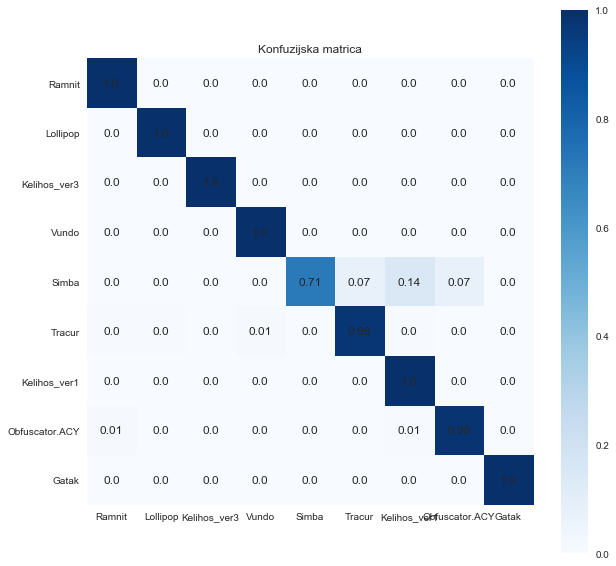

In [69]:
plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

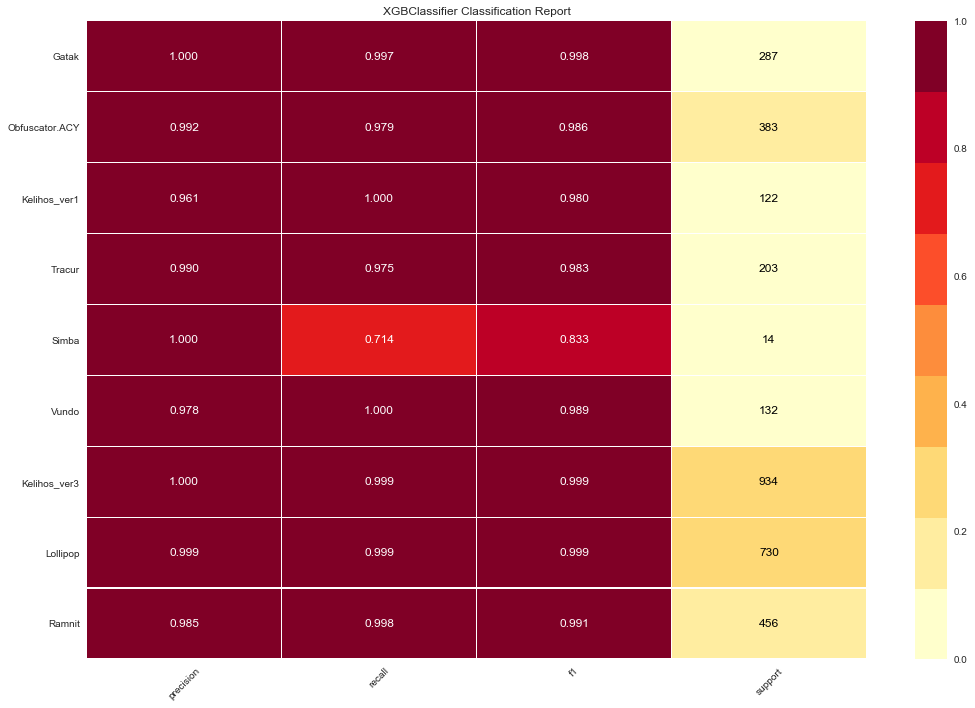

In [70]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

Broj malwarea po klasama:
dict_values([1415, 1801, 2947, 503, 59, 677, 392, 2099, 980])
Postotci malwarea po klasama:
[13.01388761151476, 16.56396578681137, 27.103835188080566, 4.62613814034765, 0.5426285293847144, 6.226432447346639, 3.6052607376069163, 19.304699714890095, 9.01315184401729]


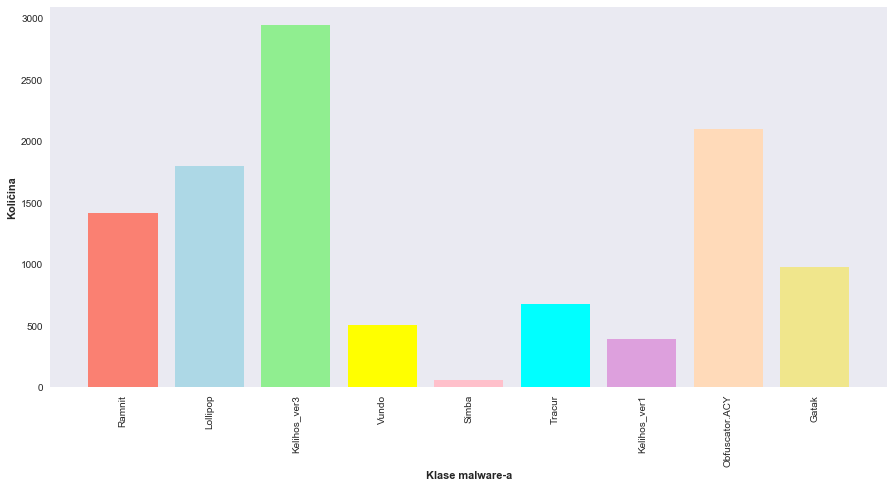

In [71]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

<span style="color:orange"><i>score:0.5355</i></span>

<br>

## Smote + težine

In [73]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.3, random_state=seed)
class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train),y_train))
    
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]
    
xgb_classifier_smote_weights = xgb.XGBClassifier(n_jobs=-1, verbose=True)
xgb_classifier_smote_weights.set_params(**best_models_params)
xgb_classifier_smote_weights.fit(X_train, y_train, sample_weight=w_array)

[(1, 2008), (2, 2008), (3, 2008), (4, 2008), (5, 2008), (6, 2008), (7, 2008), (8, 2008), (9, 2008)]


XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=False,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0.01, learning_rate=0.4, max_delta_step=0, max_depth=20,
              max_features='auto', min_child_weight=1, min_samples_leaf=2,
              min_samples_split=10, missing=None, n_estimators=165, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbose=True, verbosity=1)

In [74]:
model = xgb_classifier_smote_weights

In [75]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.027864
1,accuracy_test,0.994174
2,F1_test,0.994134
3,precision_test,0.994284
4,auc_test_ovr,0.999899
5,auc_test_ovo,0.999201
6,r2_test,0.984257


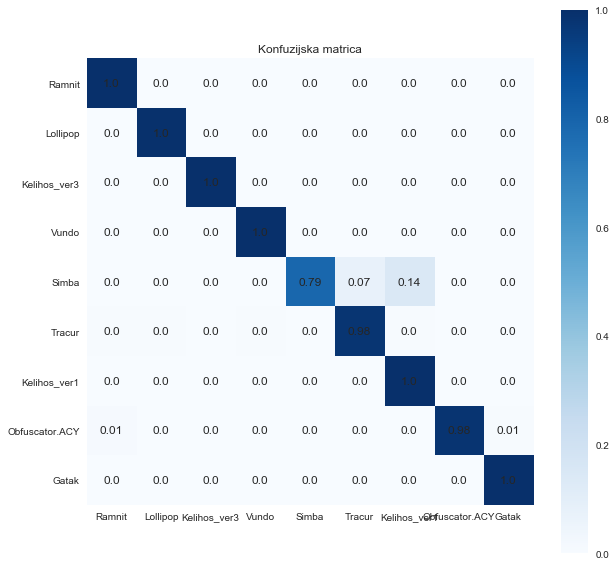

In [76]:
plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

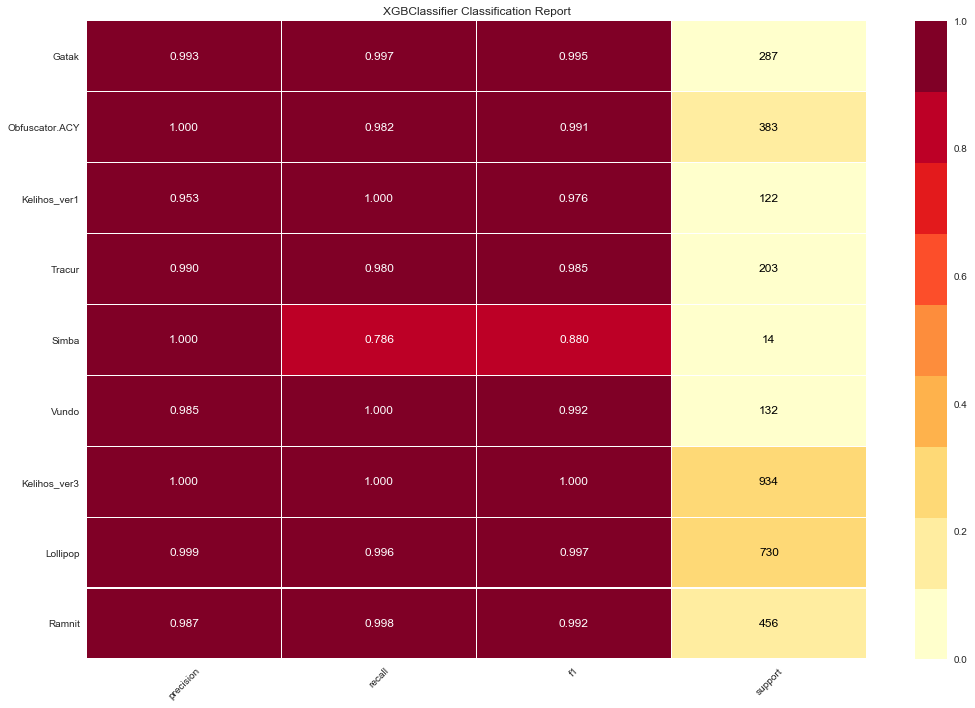

In [77]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

Broj malwarea po klasama:
dict_values([1541, 1836, 2942, 438, 85, 691, 402, 1939, 999])
Postotci malwarea po klasama:
[14.17272142003127, 16.88586406695484, 27.05784971948864, 4.028327048652626, 0.7817529660627243, 6.355191759404029, 3.6972316747907663, 17.833164719948496, 9.187896624666605]


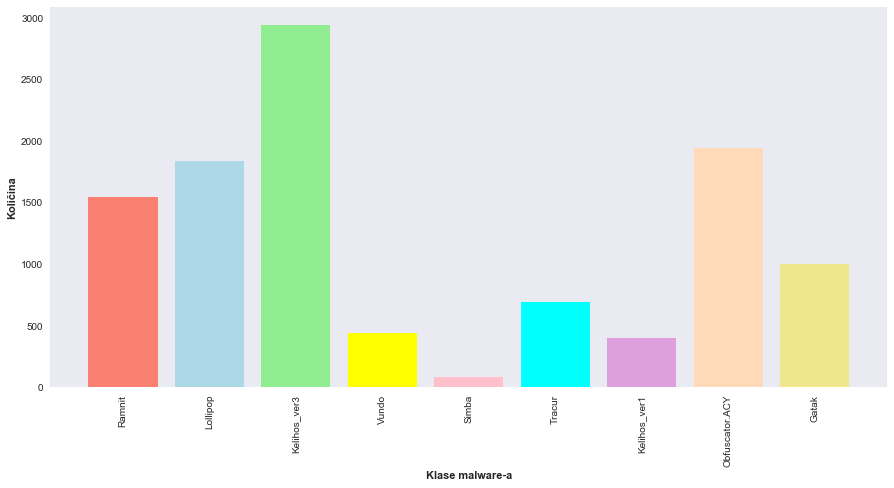

In [78]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

<span style="color:orange"><i>score:0.5576</i></span>

<br>

## ADASYN 

In [80]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.3, random_state=seed)
X_train, y_train = ADASYN().fit_resample(X_train, y_train)

print(sorted(Counter(y_train).items()))

xgb_classifier_adasyn = xgb.XGBClassifier(n_jobs=-1, verbose=True)
xgb_classifier_adasyn.set_params(**best_models_params)
xgb_classifier_adasyn.fit(X_train, y_train)

[(1, 2026), (2, 2000), (3, 2008), (4, 2008), (5, 2006), (6, 2005), (7, 2011), (8, 2027), (9, 2016)]


XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=False,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0.01, learning_rate=0.4, max_delta_step=0, max_depth=20,
              max_features='auto', min_child_weight=1, min_samples_leaf=2,
              min_samples_split=10, missing=None, n_estimators=165, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbose=True, verbosity=1)

In [81]:
model = xgb_classifier_adasyn

In [82]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.023967
1,accuracy_test,0.993254
2,F1_test,0.993093
3,precision_test,0.993309
4,auc_test_ovr,0.999956
5,auc_test_ovo,0.999864
6,r2_test,0.982877


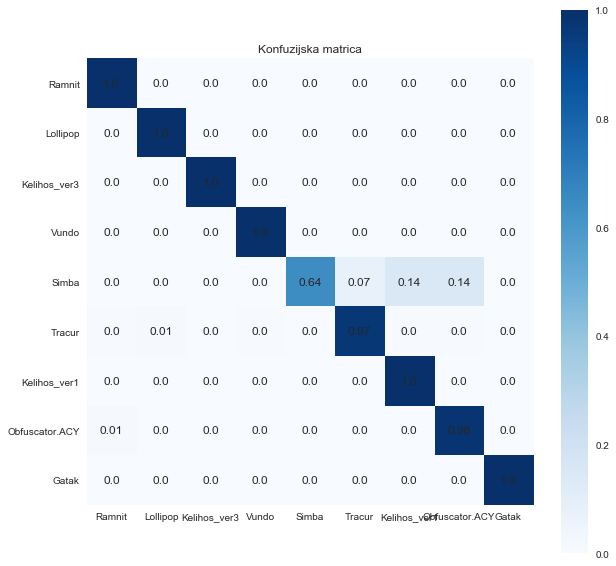

In [83]:
plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

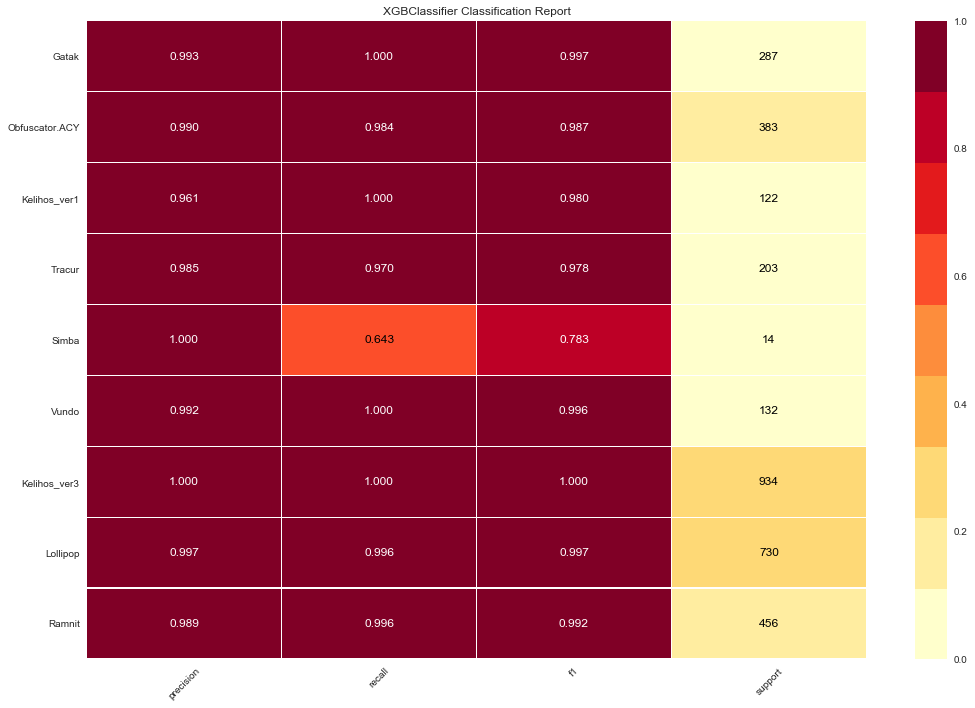

In [84]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

Broj malwarea po klasama:
dict_values([1404, 2280, 2941, 357, 60, 520, 479, 1920, 912])
Postotci malwarea po klasama:
[12.912719580612528, 20.969373677917776, 27.04865262577026, 3.2833624574634417, 0.5518256231030993, 4.7824887335601955, 4.40540789110641, 17.65841993929918, 8.38774947116711]


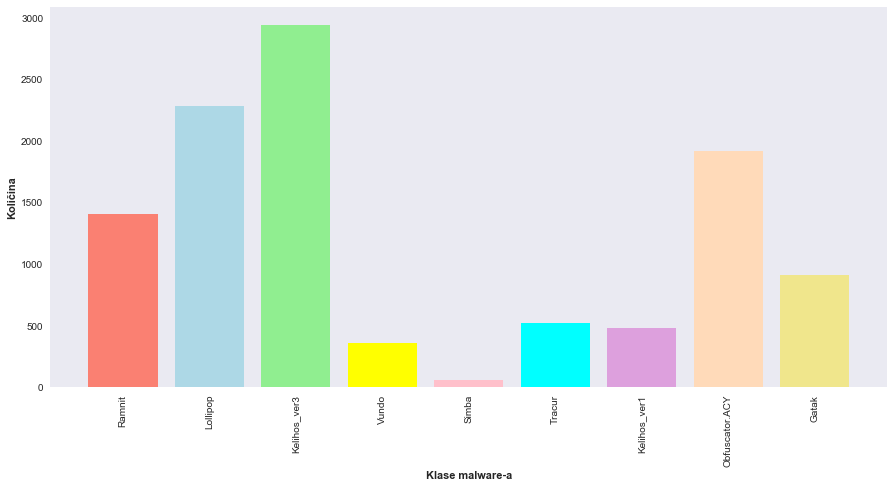

In [85]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

<span style="color:orange"><i>score:0.75690</i></span>

<br>

## ADASYN + težine

In [87]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.3, random_state=seed)

class_weights = list(class_weight.compute_class_weight('balanced', np.unique(y_train),y_train))

X_train, y_train = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]

xgb_classifier_adasyn_weights = xgb.XGBClassifier(n_jobs=-1, verbose=True)
xgb_classifier_adasyn_weights.set_params(**best_models_params)
xgb_classifier_adasyn_weights.fit(X_train, y_train, sample_weight=w_array)

[(1, 2026), (2, 2000), (3, 2008), (4, 2008), (5, 2006), (6, 2005), (7, 2011), (8, 2027), (9, 2016)]


XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=False,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0.01, learning_rate=0.4, max_delta_step=0, max_depth=20,
              max_features='auto', min_child_weight=1, min_samples_leaf=2,
              min_samples_split=10, missing=None, n_estimators=165, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbose=True, verbosity=1)

In [88]:
model = xgb_classifier_adasyn_weights

In [89]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.021467
1,accuracy_test,0.994480
2,F1_test,0.994433
3,precision_test,0.994545
4,auc_test_ovr,0.999862
5,auc_test_ovo,0.999772
6,r2_test,0.987147


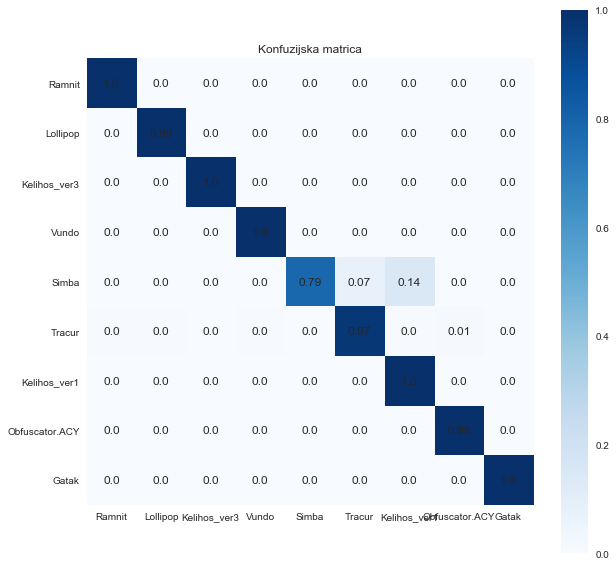

In [90]:
plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

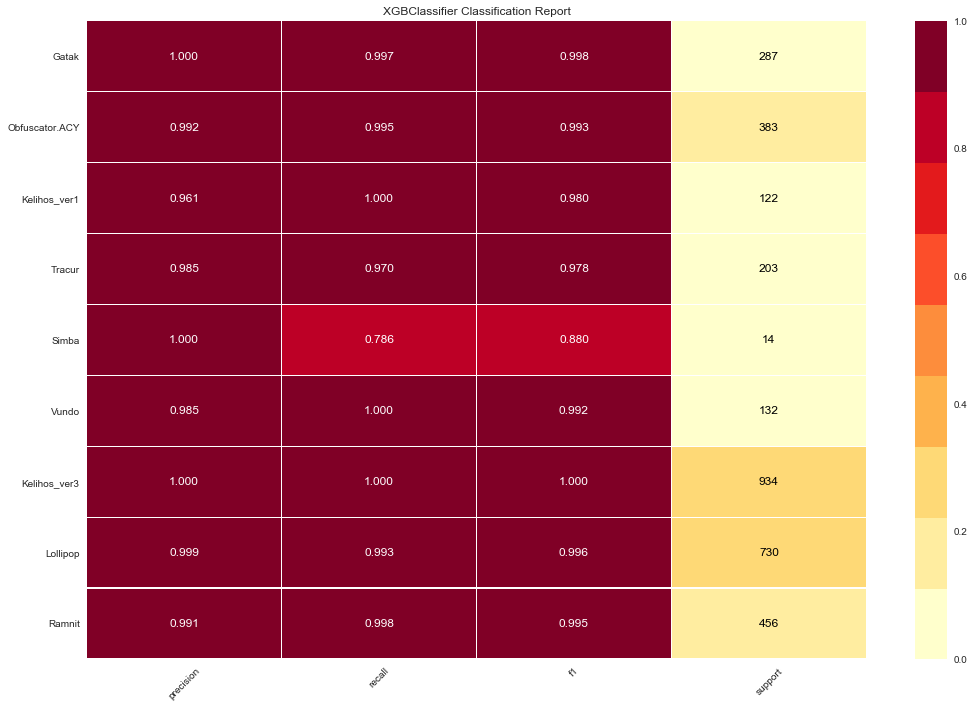

In [91]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

Broj malwarea po klasama:
dict_values([1490, 2063, 2901, 370, 49, 598, 465, 1975, 962])
Postotci malwarea po klasama:
[13.703669640393636, 18.973604341028235, 26.680768877034854, 3.402924675802446, 0.45065759220086454, 5.4998620435942245, 4.276648579049021, 18.164260093810356, 8.84760415708636]


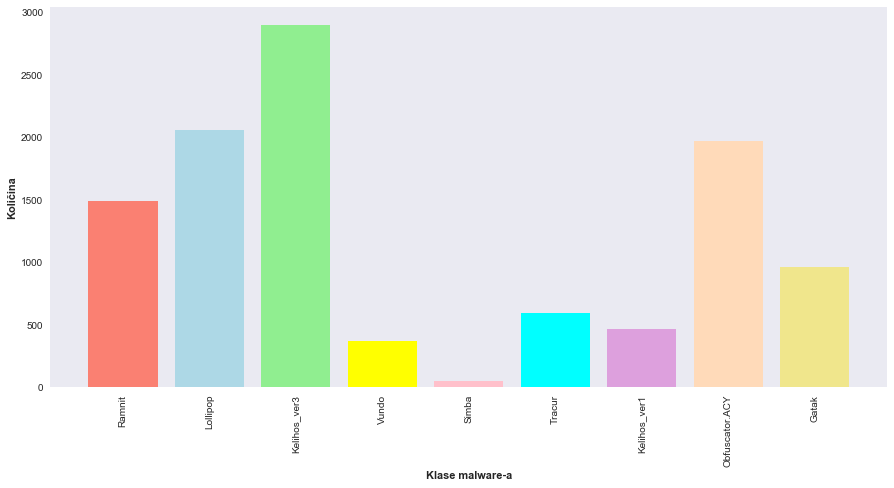

In [92]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

<span style="color:orange"><i>score:0.811</i></span>

<br>

## RandomUnderSample

In [94]:
#RandomUnderSampler
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.3, random_state=seed)
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

xgb_classifier_rus = xgb.XGBClassifier(n_jobs=-1, verbose=True)
xgb_classifier_rus.set_params(**best_models_params)
xgb_classifier_rus.fit(X_train, y_train)

[(1, 1085), (2, 1747), (3, 28), (4, 343), (5, 28), (6, 548), (7, 276), (8, 845), (9, 726)]


XGBClassifier(base_score=0.5, booster='gbtree', bootstrap=False,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0.01, learning_rate=0.4, max_delta_step=0, max_depth=20,
              max_features='auto', min_child_weight=1, min_samples_leaf=2,
              min_samples_split=10, missing=None, n_estimators=165, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbose=True, verbosity=1)

In [95]:
model = xgb_classifier_rus

In [96]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.025030
1,accuracy_test,0.992640
2,F1_test,0.992485
3,precision_test,0.992711
4,auc_test_ovr,0.999781
5,auc_test_ovo,0.999612
6,r2_test,0.978305


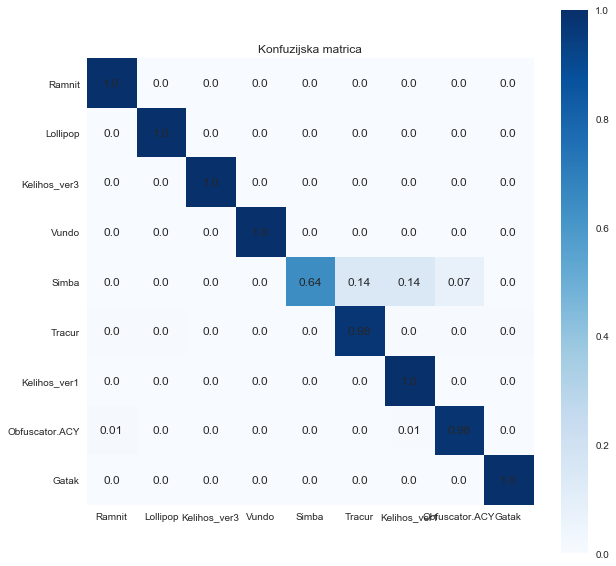

In [97]:
plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

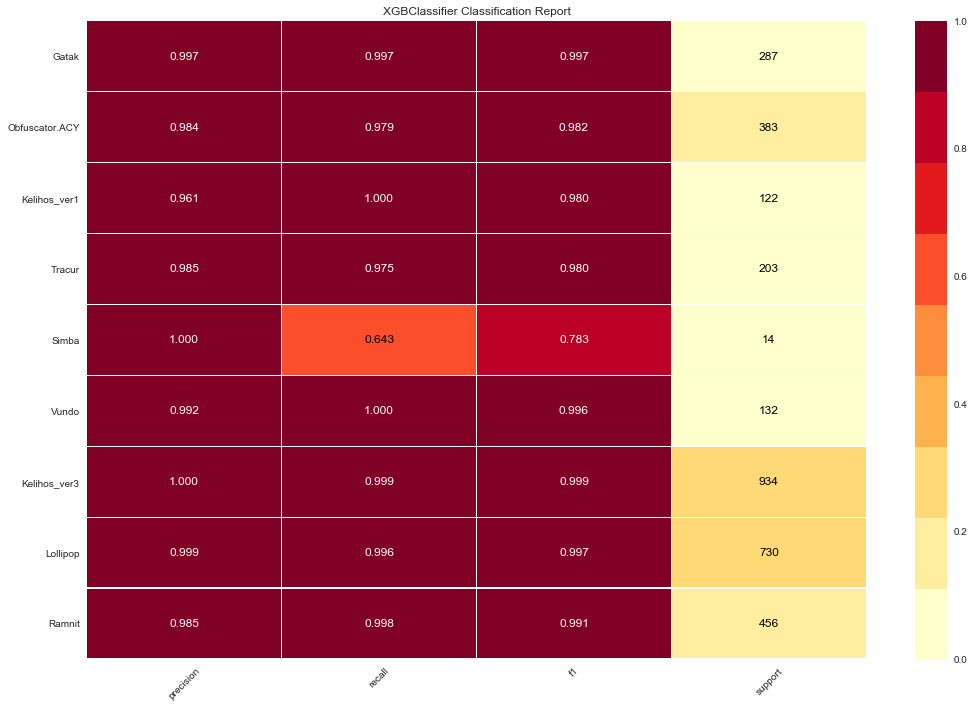

In [98]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

Broj malwarea po klasama:
dict_values([1186, 1681, 2862, 480, 40, 494, 396, 2753, 981])
Postotci malwarea po klasama:
[10.907753150004599, 15.460314540605168, 26.32208222201784, 4.414604984824795, 0.3678837487353996, 4.543364296882185, 3.642049112480456, 25.31959900671388, 9.022348937735677]


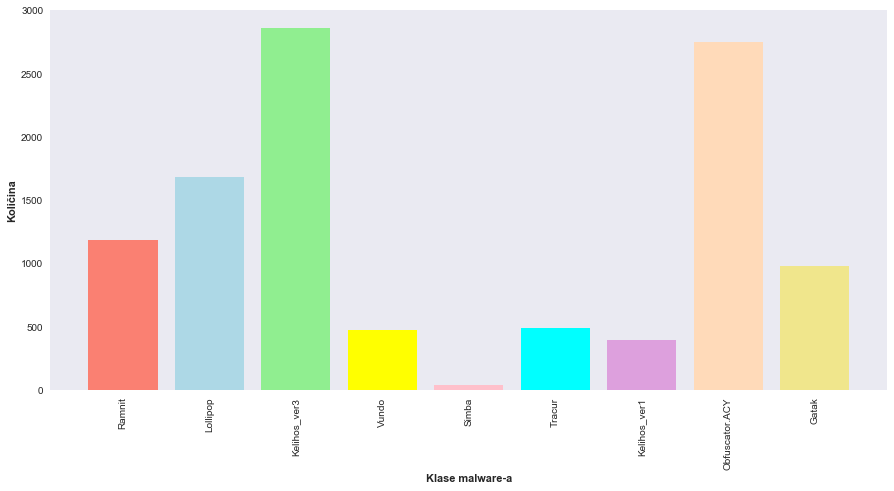

In [99]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

<span style="color:orange"><i>score:0.79485</i></span>

<br>

## Bagging

In [101]:
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.3, random_state=seed)
exgb_classifier = xgb.XGBClassifier(n_jobs=-1, verbose=True)
exgb_classifier.set_params(**best_models_params)

bagging_class = BaggingClassifier(base_estimator=exgb_classifier, n_estimators=10, random_state=seed)
bagging_class.fit(X_train, y_train)

BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                               bootstrap=False,
                                               colsample_bylevel=1,
                                               colsample_bynode=1,
                                               colsample_bytree=1, gamma=0.01,
                                               learning_rate=0.4,
                                               max_delta_step=0, max_depth=20,
                                               max_features='auto',
                                               min_child_weight=1,
                                               min_samples_leaf=2,
                                               min_samples_split=10,
                                               missing=None, n_estimators=165,
                                               n_jobs=-1, nthread=None,
                                               objective='binary:logistic'

In [102]:
model = bagging_class

In [103]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.021764
1,accuracy_test,0.994174
2,F1_test,0.994013
3,precision_test,0.994221
4,auc_test_ovr,0.999881
5,auc_test_ovo,0.999704
6,r2_test,0.979254


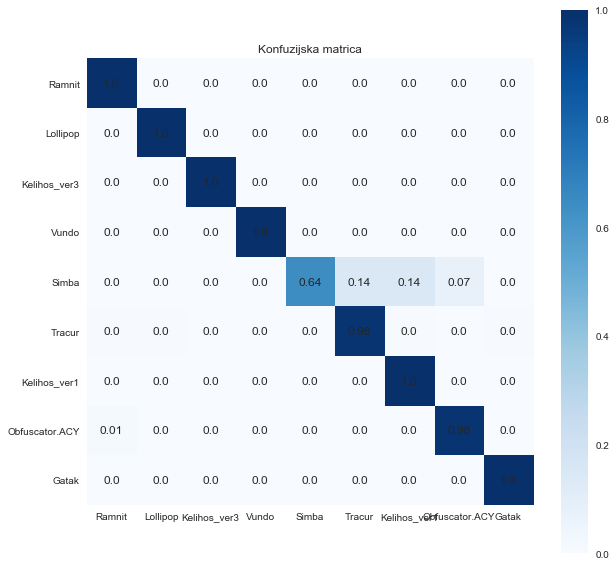

In [104]:
plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

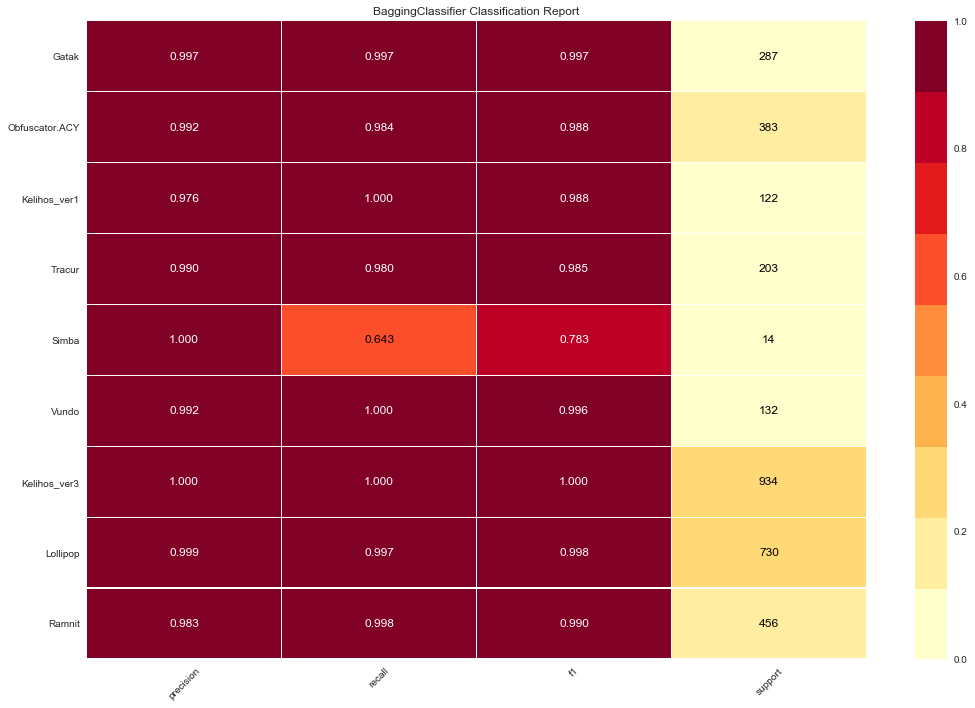

In [105]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

Broj malwarea po klasama:
dict_values([1603, 2276, 2955, 473, 82, 570, 329, 1532, 1053])
Postotci malwarea po klasama:
[14.742941230571137, 20.932585303044238, 27.177411937827646, 4.350225328796101, 0.7541616849075692, 5.242343419479444, 3.0258438333486617, 14.089947576565805, 9.684539685459395]


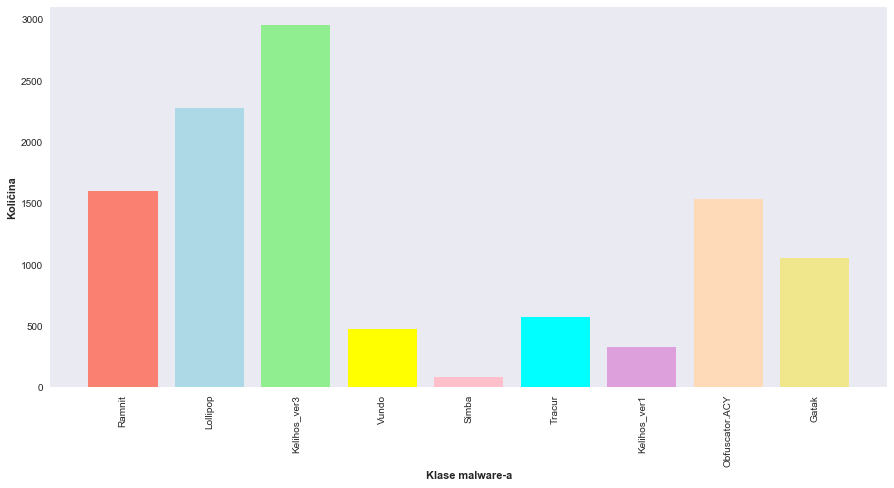

In [106]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

<span style="color:orange"><i>score:0.53079</i></span>

<br>

## Bagging + SMOTE 

In [114]:
#Bagging + adasyn + weights
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.3, random_state=seed)

X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

exgb_classifier = xgb.XGBClassifier(n_jobs=-1, verbose=True)
exgb_classifier.set_params(**best_models_params)

bagging_class_smote = BaggingClassifier(base_estimator=exgb_classifier, n_estimators=10, random_state=seed)
bagging_class_smote.fit(X_train, y_train)

[(1, 2008), (2, 2008), (3, 2008), (4, 2008), (5, 2008), (6, 2008), (7, 2008), (8, 2008), (9, 2008)]


BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                               bootstrap=False,
                                               colsample_bylevel=1,
                                               colsample_bynode=1,
                                               colsample_bytree=1, gamma=0.01,
                                               learning_rate=0.4,
                                               max_delta_step=0, max_depth=20,
                                               max_features='auto',
                                               min_child_weight=1,
                                               min_samples_leaf=2,
                                               min_samples_split=10,
                                               missing=None, n_estimators=165,
                                               n_jobs=-1, nthread=None,
                                               objective='binary:logistic'

In [122]:
model = bagging_class_smote

In [116]:
basic_results_xgb = model_results(model, X_test, y_test)
basic_results_xgb

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.020662
1,accuracy_test,0.993560
2,F1_test,0.993407
3,precision_test,0.993629
4,auc_test_ovr,0.999954
5,auc_test_ovo,0.999870
6,r2_test,0.980936


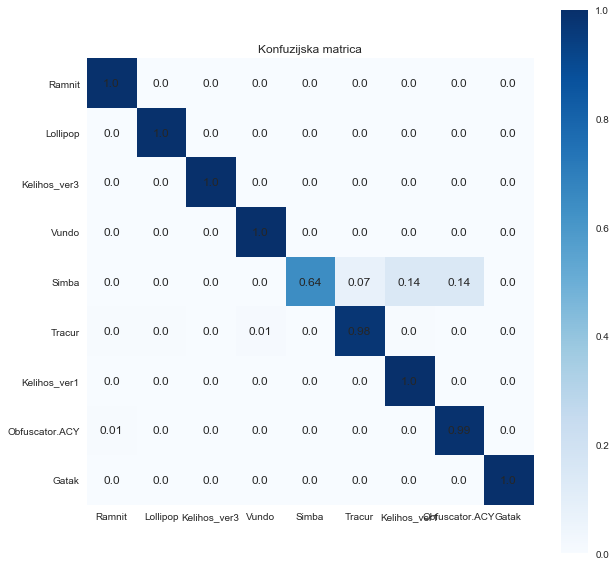

In [117]:
plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

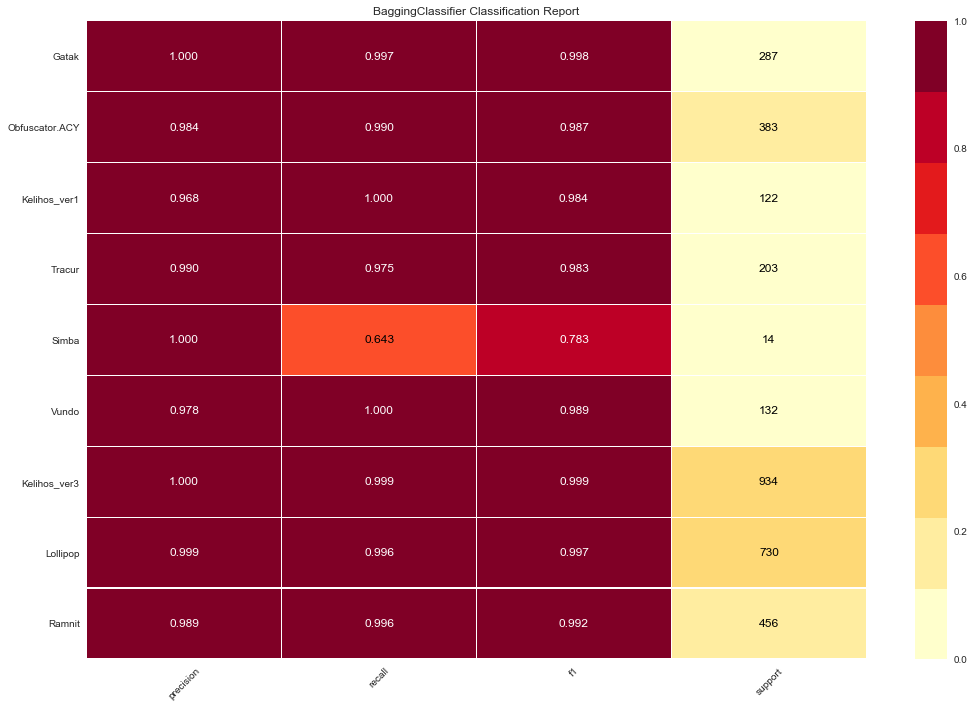

In [118]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

Broj malwarea po klasama:
dict_values([1428, 1839, 2944, 490, 53, 699, 401, 2113, 906])
Postotci malwarea po klasama:
[13.133449829853767, 16.91345534811, 27.076243906925413, 4.506575922008645, 0.48744596707440446, 6.428768509151109, 3.688034581072381, 19.43345902694748, 8.332566908856801]


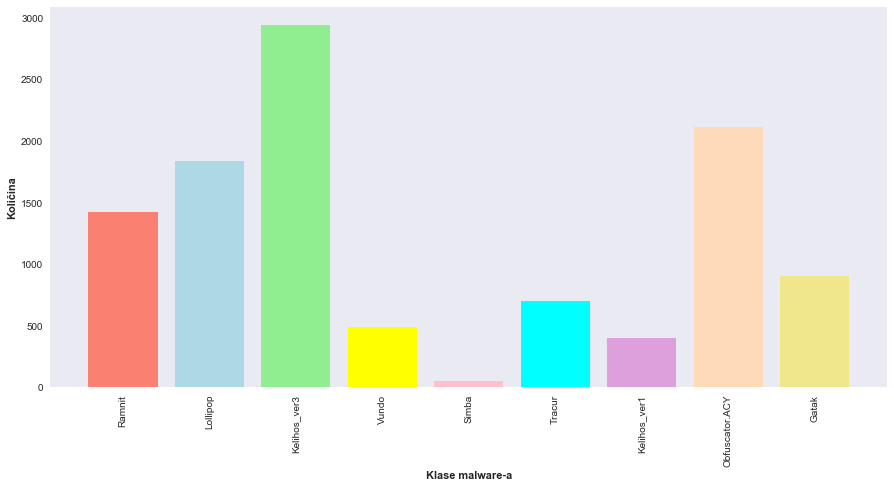

In [119]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

<span style="color:orange"><i>score:0.56941</i></span>

<br>

***


# Submission

Sada ćemo kreirati datoteku s kojom ćemo provjeriti ( _logloss_ ) točnost _test_ skupa na [Kaggle-u](https://www.kaggle.com/c/malware-classification/overview).

In [120]:
# define model to use for submission
# model = bagging_class

In [123]:
# make a submisson file
name = input("Ime za submisson file?")
submission = make_submisson_file(md5hash_test, model.predict_proba(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]), name)

Ime za submisson file?bagging_smote_186f


In [ ]:
submission.head()

In [ ]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

<span style="color:orange"><i>U odnosu na training set možemo očekivati istu distribuciju podataka u test setu. Lolipopa ima dosta manje, sa 22,79% pao je na 16,76%! Ostali su više manje okej. Problem još mogu biti  Obfuscator koji je prije bio 11.29% a sada je 17.14%!!! Također, Gatak je prije bio 9.31% a sad je 11.4%.</i></span>

<br><br><br><br>

***

## RUSKI

<span style="color:orange"><i>Ovo sam vam napisala na slack.</i></span>

In [ ]:
ruski_submission = pd.read_csv('ruski.238671')
ruski_submission.head()

In [ ]:
ruske_klape = []
for i in range(10873):
    ruske_klape.append(np.argmax(ruski_submission.iloc[i,1:].values) + 1)
    
ruski_klase = pd.concat([ ruski_submission['Id'], pd.DataFrame(ruske_klape)], axis=1, sort=False)

In [ ]:
ruski_klase.columns = ["Id", "Class"]
#ruski_klase.to_csv("ruske_klase.csv")
ruski_klase.head()

In [ ]:
draw_malware_distribution_over_classes(ruski_klase["Class"])

<br>

***